# Introduction
I look at 50 years of league tables for various leagues to see if they are becoming less competitive. The evidence suggests that over time leagues are generally becoming more monopolistic, particularly the top 5 leagues.


The [Herfindahl-Hirschman Index (HHI)](https://www.investopedia.com/terms/h/hhi.asp) is a metric used in economics to measure monopolistic power in an industry. You take the 50 largest companies in an industry -say the companies have $s_1,s_2,...,s_{50}$ percentage market share, then the index is defined to be
$$ HHI = \Sigma_i^{50} s_i^2$$ 
I will apply this metric to football league tables in order to quantify the extent to which leagues are becoming less competitive.

In [24]:
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from urllib.request import urlopen
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
import pickle
import copy

# Getting the data
First I get the data. The league tables all come from wikipedia. I define a function to scrape a league table from a url for a league season (eg https://en.wikipedia.org/wiki/1995-96_Bundesliga)

In [25]:
def league_table_scraper(url):
  
  while True:
    try:
       req = urllib.request.urlopen(url)
    except urllib.error.HTTPError as e:
        return []
    except urllib.error.URLError as e:
        return []
    else:
      #print('URL Exists')
      html = urlopen(url) 
      soup = BeautifulSoup(html, 'html.parser')

      tables = soup.find_all('table')
      league_table_no = np.nan
      for i,table in enumerate(tables):
        rows=table.find_all('tr')
        heads = rows[0].find_all('th')
        if (len(heads)>8):
          h0 = heads[0].text
          if(h0.find('Pos')>=0):
            league_table_no = i
            break
      
      if np.isnan(league_table_no):
        return []

      league_table = tables[league_table_no]
      table_headers = league_table.find_all('th')
      col_heads = np.array([h.text.replace('\n','') for h in table_headers])
      idx_Pos = np.where(col_heads=='Pos')[0][0]
      idx_team = idx_Pos+1
      idx_Pts = np.where(col_heads=='Pts')[0][0]

      rows = league_table.find_all('tr')
      team = [];pts = [];pos=[];
      for r in rows[1:]:
        els = r.find_all(['td','th'])
        if len(els)>=8:
          if not np.all(np.array([e.text.replace('\n','') for e in els])==''):  # ignore empty rows
            team.append(els[idx_team].text.replace('\n',''))
            pos.append(int(els[idx_Pos].text.replace('\n','').replace('.','')))
            pts.append(els[idx_Pts].text.replace('\n',''))

      table = pd.DataFrame({'Pos':pos,'Team':team,'Pts':pts})

      return table
url = 'https://en.wikipedia.org/wiki/1995%E2%80%9396_Bundesliga'
table = league_table_scraper(url)
print(table)

    Pos                      Team Pts
0     1     Borussia Dortmund (C)  68
1     2             Bayern Munich  62
2     3                Schalke 04  56
3     4  Borussia Mönchengladbach  53
4     5              Hamburger SV  50
5     6             Hansa Rostock  49
6     7             Karlsruher SC  48
7     8               1860 Munich  45
8     9             Werder Bremen  44
9    10             VfB Stuttgart  43
10   11               SC Freiburg  42
11   12                1. FC Köln  40
12   13        Fortuna Düsseldorf  40
13   14          Bayer Leverkusen  38
14   15              FC St. Pauli  38
15   16  1. FC Kaiserslautern (R)  36
16   17   Eintracht Frankfurt (R)  32
17   18         KFC Uerdingen (R)  26


I try find the URL for every league season since 1969 for the countries on my. Most leagues seem to have changed name at least once and many countries run off their league in a single calendar year, so I often have to try several combinations until I find the correct url.

In [26]:
class league:
  def __init__(self,country,names):
    self.country = country
    self.names = names

    self.tables=[]
    self.season=[]
    self.url=[]



  def populate_tables(self,start_year,end_year):
    for i in range(start_year,end_year):
      start_str = str(i)
      end_str = str(np.mod(i+1,100)).zfill(2)
      if i == 1999:
        end_str = '2000'
      
      print(i)

      for name in self.names:
        url = 'https://en.wikipedia.org/wiki/'+start_str+'-'+end_str+'_'+name
        print(url)
        table = league_table_scraper(url)
        if len(table) > 0:
          break
        else: # try single year season
          url = 'https://en.wikipedia.org/wiki/'+start_str+'_'+name
          print(url)
          table = league_table_scraper(url)
          if len(table) > 0:
            break
        #otherwise try the other names

      if len(table) > 0:
        self.tables.append(table)
        self.url.append(url)
        self.season.append(start_str+'-'+end_str)


Now I populate all the tables (I have also saved all the data).



In [27]:
league_details = pd.read_csv('/content/data/League_details2.csv')

league_details = league_details.fillna('')
all_leagues = []

read_tables = False
if read_tables:
  for r in league_details.loc[14:].iterrows():
    names = r[1][1:].values
    names = names[~(names=='')]
    my_league = league(r[1].Country,names)
      
    my_league.populate_tables(1920,2020)
    all_leagues.append(my_league)
  my_league.country
else:
  all_leagues = pd.read_pickle("/content/data/league_data_all.dat")



# Analysing the data - FA Premier League

First a note on HHI. I calculate the HHI for the league winners over 10 seasons. For example if Club A won the league 6 times (60%) and Club B 4 times (40%) in that period, the index would be  $60^2+40^2=5,200$. I denote this by  $HHI_{winners}$  - the maximum value is 10,000 (if one team won the league each year in the window) and the minimum is 1,000.

Then I look at all the teams that finished in a top 5 position in any of the 10 seasons in the window - each appearance is thus worth 2%. Since there must be at least 5 clubs, the maximum vaue of $HHI_{top5}$  is 2,000 and the minimum is 200.

First I will examine the number of premier league champions by decade.

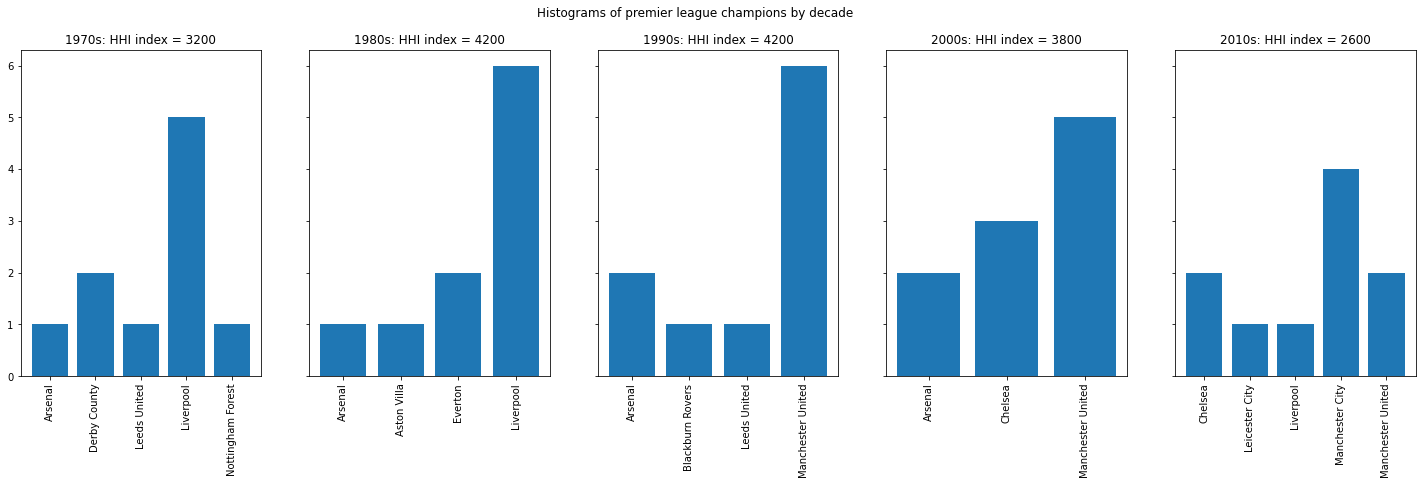

In [28]:
country_list = [l.country for l in all_leagues]
idx_pl = np.where(np.array(country_list)=='England')[0][0]
pl = all_leagues[idx_pl]
decade = np.array([str(int(np.floor(int(s.split('-')[0])/10)*10))+"s" for s in pl.season])
pl.url
winners = np.array([t.loc[t.Pos==1,'Team'] for t in pl.tables])
winners = [re.sub('[\(\[].*[\)\]]','',w[0]).strip() for w in winners];winners=np.array(winners)

fig,axs = plt.subplots(1,5,figsize=(25,6),sharey=True)
fig.suptitle('Histograms of premier league champions by decade')
for i,d in enumerate(np.unique(decade)[-5:]):
  v,c = np.unique(winners[np.where(decade==d)[0]],return_counts=True)
  HHI = np.sum((c*10)**2)
  ax = axs[i]
  ax.bar(v,c)
  ax.xaxis.set_tick_params(rotation=90)
  ax.set_title(d+ ': HHI index = {}'.format(HHI))
plt.show()



The 2010s are the only decade in the period in which no club won the league at least 5 times. Also the HHI index has its lowest reading in the 2010s. In terms of league winners the premier league looks to be relatively competitive.
Next I look at top 5 finishes.

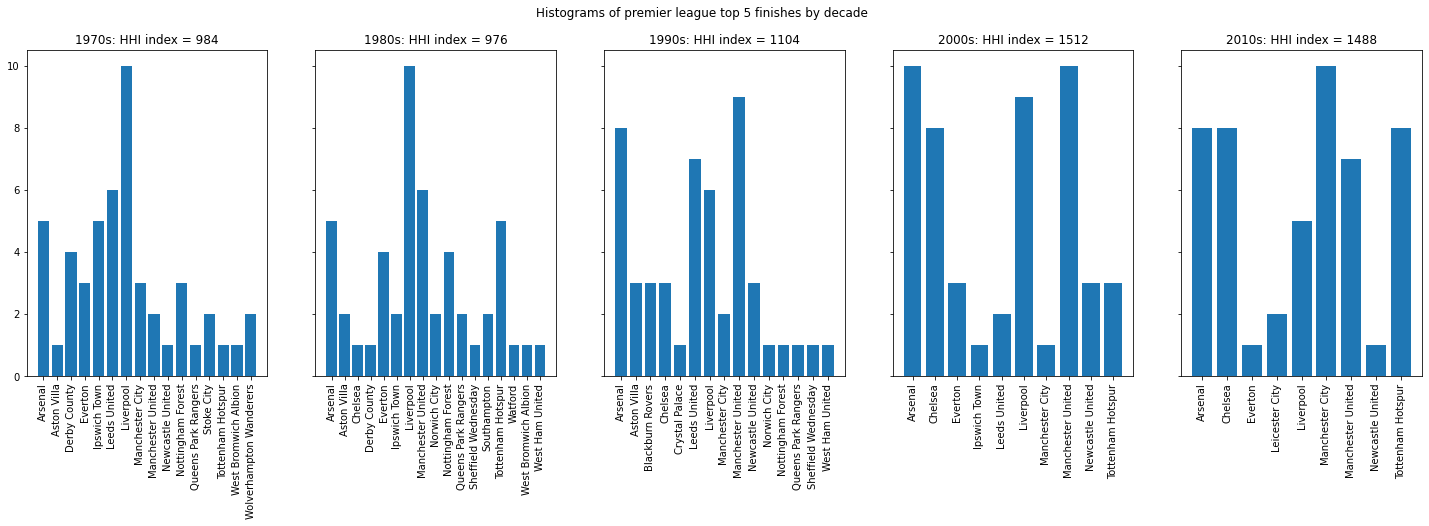

In [29]:
top_5s  = np.ravel(np.array([t.loc[t.Pos <=5,'Team'] for t in pl.tables]))
top_5s = [re.sub('[\(\[].*[\)\]]','',w).strip() for w in top_5s];top_5s=np.array(top_5s)
top_5s=top_5s.reshape(winners.shape[0],5)
decade = np.array([str(int(np.floor(int(s.split('-')[0])/10)*10))+"s" for s in pl.season])

fig,axs = plt.subplots(1,5,figsize=(25,6),sharey=True)
fig.suptitle('Histograms of premier league top 5 finishes by decade')
for i,d in enumerate(np.unique(decade)[-5:]):
  v,c = np.unique(np.ravel(top_5s[np.where(decade==d)[0]]),return_counts=True)
  HHI = np.sum((c*2)**2)
  ax = axs[i]
  ax.bar(v,c)
  ax.xaxis.set_tick_params(rotation=90)
  ax.set_title(d+ ': HHI index = {}'.format(HHI))
plt.show()


This shows a different picture. In the 1970s and again in the 1980s only one club finised in the top 10 more than 6 times. This number increased to 3 in the 1990s, 4 in the 2000s and 5 in the 2010s. We start to see the emergence of a dominant group of clubs (note the increasing HHI), even if the eventual winner is not becoming more predictable. Note however that there is some mobility - Spurs and Man City moved into the dominant group in the 2010s while Leeds dropped out of it in the 2000s.

We don't need to restrict ourselves to looking at decades - we can look at 10 season rolling windows (eg 1970-71 to 1979-80, 1971-72 to 1980-81 etc) 

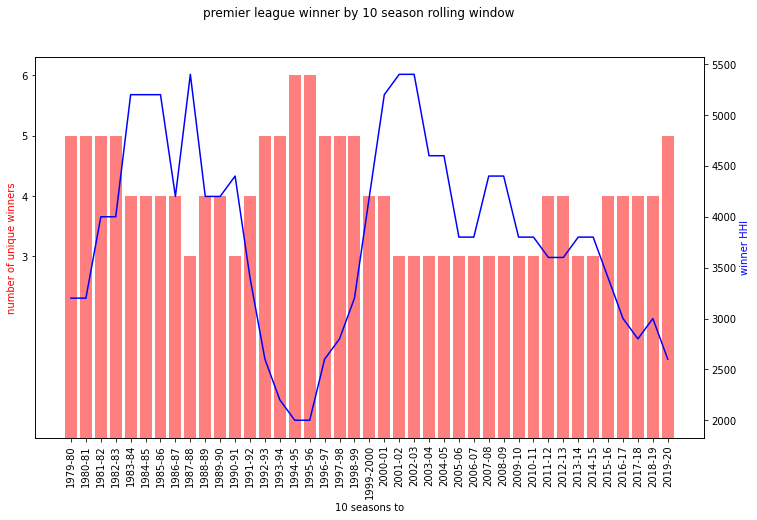

In [30]:

def rolling_window_stats(league,window_length,start_index=0):

  seasons_axis = []
  n_seasons = len(league.tables[start_index:])
  winners = np.array([t.loc[t.Pos==1,'Team'] for t in league.tables[start_index:]])
  winners = [re.sub('[\(\[].*[\)\]]','',w[0]).strip() for w in winners];
  winners = [re.sub('\\xa0',' ',w).strip() for w in winners];
  winners=np.array(winners)

  top_5s  = np.ravel(np.array([t.loc[t.Pos <=5,'Team'] for t in league.tables[start_index:]]))
  top_5s = [re.sub('[\(\[].*[\)\]]','',w).strip() for w in top_5s]
  top_5s = [re.sub('\\xa0',' ',w).strip() for w in top_5s];top_5s=np.array(top_5s)
  top_5s=top_5s.reshape(n_seasons,5)

  seasons_axis = []
  unique_winners_rolling = []
  unique_top5_rolling = []
  hhi_winners_rolling = []
  hhi_top_5_rolling = []
  for i in range(n_seasons-9):
    v,c = np.unique(winners[i:i+window_length],return_counts=True)
    unique_winners_rolling.append(v.shape[0])
    hhi_winners_rolling.append(np.sum(((100/window_length)*c)**2))
    v_5,c_5 = np.unique(top_5s[i:i+window_length],return_counts=True)
    unique_top5_rolling.append(v_5.shape[0])
    hhi_top_5_rolling.append(np.sum(((100/(window_length*5))*c_5)**2))
    seasons_axis.append(league.season[start_index+i+window_length-1])
  return unique_winners_rolling, unique_top5_rolling, hhi_winners_rolling, hhi_top_5_rolling,seasons_axis

def plot_counts_hhi(uniques,hhis,league_name,kind,window_length,seasons_axis):
    fig,ax1 = plt.subplots(figsize=(12,7))
    fig.suptitle(league_name+' '+ kind+' by {} season rolling window'.format(window_length))
    #ax1.plot(uniques,color='r',label='Number of unique '+kind+'s');
    ax1.bar(range(len(uniques)),uniques,color='r',label='Number of unique '+kind+'s',alpha=0.5);
    #ax1.legend(loc='best',frameon=False);
    ax1.set_xticks(range(len(seasons_axis)))
    ax1.set_xticklabels((seasons_axis),rotation=90)
    ax1.set_xlabel('10 seasons to')
    ax1.set_ylabel('number of unique '+kind+'s',color='r')
    ax1.set_yticks(range(np.min(uniques),np.max(uniques)+1))
    ax2 = ax1.twinx()
    ax2.plot(hhis,label=kind+' HHI',color='b');
    #ax2.legend(loc='best',frameon=False);
    ax2.set_ylabel(kind+' HHI',color='b');

window_length=10
idx_start = np.where(np.array(pl.season)=='1970-71')[0][0]
unique_winners_rolling, unique_top5_rolling, hhi_winners_rolling, hhi_top_5_rolling,seasons_axis = rolling_window_stats(pl,window_length,idx_start)

plot_counts_hhi(unique_winners_rolling,hhi_winners_rolling,'premier league','winner',window_length,seasons_axis);


Again, for winners, the picture looks relatively healthy - there have been 5 winners in the latest window and the HHI is at a low level compared to the history.

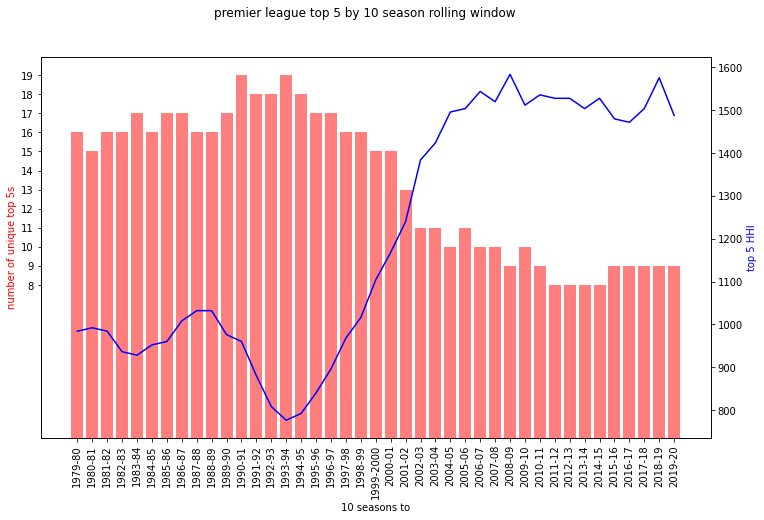

In [31]:
plot_counts_hhi(unique_top5_rolling,hhi_top_5_rolling,'premier league','top 5',window_length,seasons_axis)

There is a clear trend in top 5 finishers - the HHI has been relatively stable for 15 seasons but in the 1- windows preceeding that there was big increase in this metric - perhaps this can be traced to the advent of the premier league (1992-93).







# Other leagues

So much for the premier league - what about the other top 5 leagues in europe.
# 1. Bundesliga 

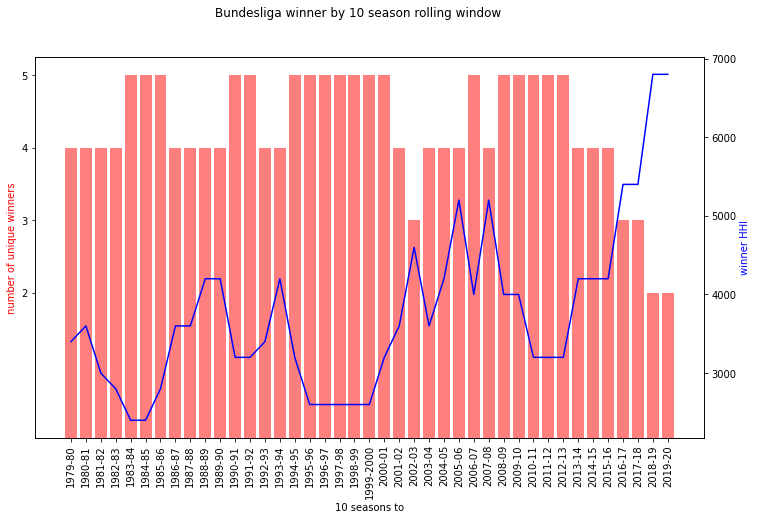

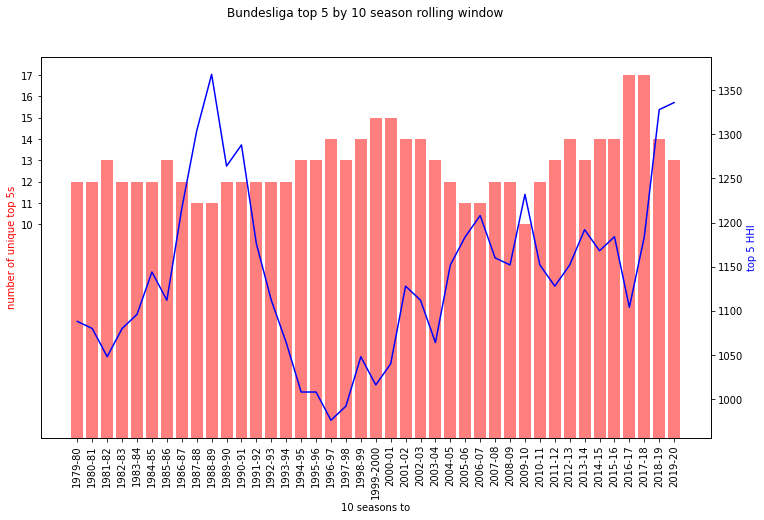

In [32]:
idx_bl = np.where(np.array(country_list)=='Germany')[0][0]
bl = all_leagues[idx_bl]
idx_start = np.where(np.array(bl.season)=='1970-71')[0][0]
unique_winners_rolling, unique_top5_rolling, hhi_winners_rolling, hhi_top_5_rolling,seasons_axis = rolling_window_stats(bl,window_length,idx_start)
plot_counts_hhi(unique_winners_rolling,hhi_winners_rolling,'Bundesliga','winner',window_length,seasons_axis);
plot_counts_hhi(unique_top5_rolling,hhi_top_5_rolling,'Bundesliga','top 5',window_length,seasons_axis);


#2. Serie A

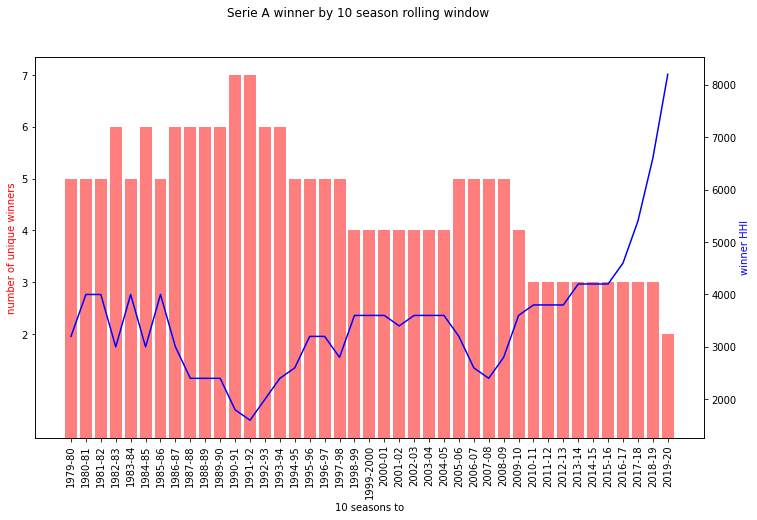

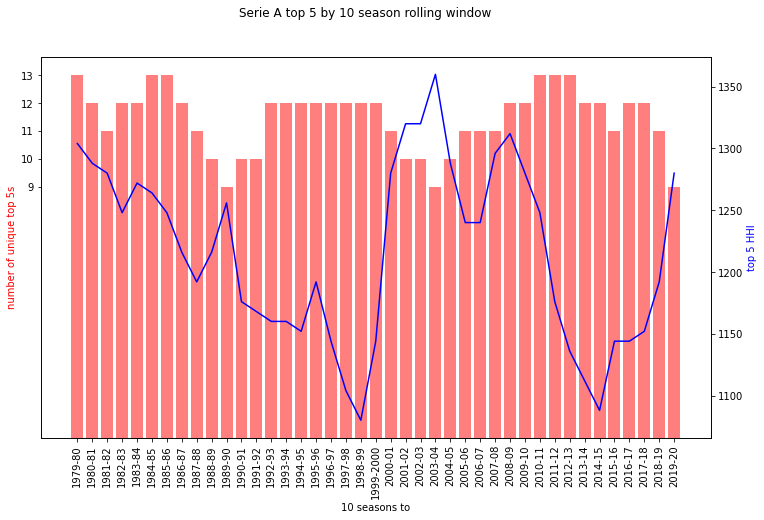

In [33]:
idx_sa = np.where(np.array(country_list)=='Italy')[0][0]
sa = all_leagues[idx_sa]
idx_start = np.where(np.array(sa.season)=='1970-71')[0][0]
unique_winners_rolling, unique_top5_rolling, hhi_winners_rolling, hhi_top_5_rolling,seasons_axis = rolling_window_stats(sa,window_length,idx_start)
plot_counts_hhi(unique_winners_rolling,hhi_winners_rolling,'Serie A','winner',window_length,seasons_axis);
plot_counts_hhi(unique_top5_rolling,hhi_top_5_rolling,'Serie A','top 5',window_length,seasons_axis);


#3. La Liga

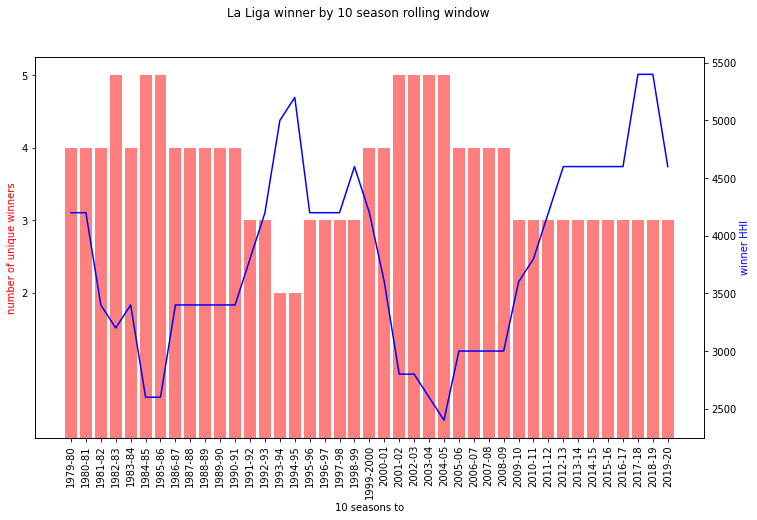

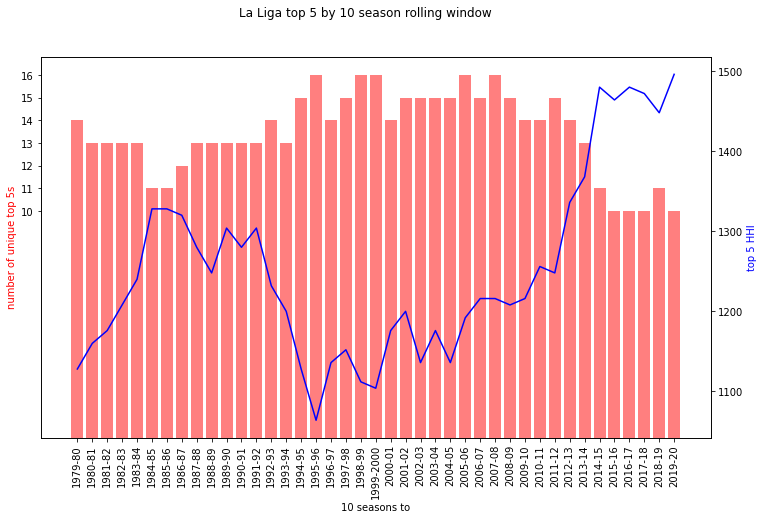

In [34]:
idx_ll = np.where(np.array(country_list)=='Spain')[0][0]
ll = all_leagues[idx_ll]
idx_start = np.where(np.array(ll.season)=='1970-71')[0][0]
unique_winners_rolling, unique_top5_rolling, hhi_winners_rolling, hhi_top_5_rolling,seasons_axis = rolling_window_stats(ll,window_length,idx_start)
plot_counts_hhi(unique_winners_rolling,hhi_winners_rolling,'La Liga','winner',window_length,seasons_axis);
plot_counts_hhi(unique_top5_rolling,hhi_top_5_rolling,'La Liga','top 5',window_length,seasons_axis);


# 4. Ligue Un

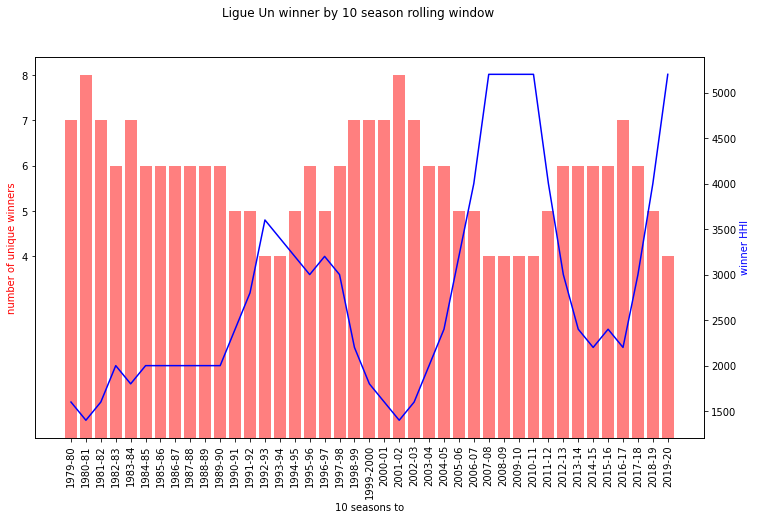

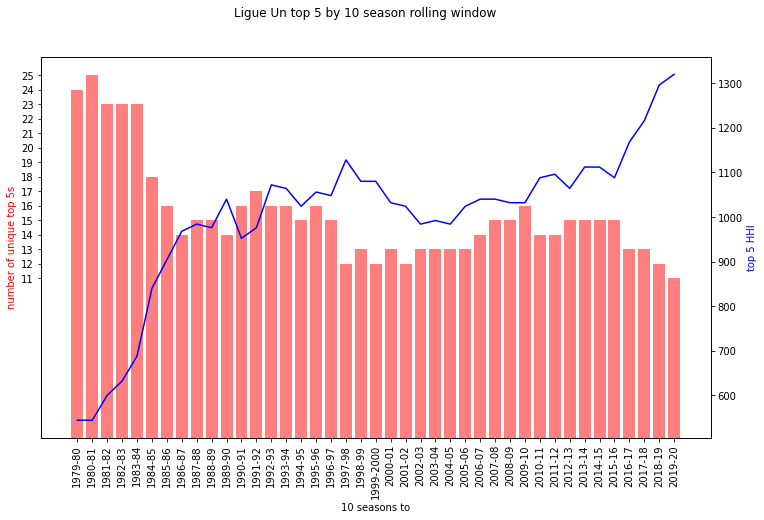

In [35]:
idx_l1 = np.where(np.array(country_list)=='France')[0][0]
l1 = all_leagues[idx_l1]
idx_start = np.where(np.array(l1.season)=='1970-71')[0][0]
unique_winners_rolling, unique_top5_rolling, hhi_winners_rolling, hhi_top_5_rolling,seasons_axis = rolling_window_stats(l1,window_length,idx_start)
plot_counts_hhi(unique_winners_rolling,hhi_winners_rolling,'Ligue Un','winner',window_length,seasons_axis);
plot_counts_hhi(unique_top5_rolling,hhi_top_5_rolling,'Ligue Un','top 5',window_length,seasons_axis);


Like the premier leauge, these leagues all show a clear upward trend in the top 5 HHI. However there is also a clear upward trend in the winners HHI - particularly this is evident in the Bundesliga, Serie A and Ligue Un where the superclubs of Bayern Munich, Juventus and PSG are dominant. Spain has 2 superclubs so the trend is less dramatic. Somehow the premier league has managed to avoid this fate with several clubs capable of winning the league in any given year.

# All leagues

Now let's look at the aggregate picture across all leagues in the dataset.

In [36]:
window_length=10
start_year = '1970'
n_leagues = len(all_leagues)
n_seasons = 50
unique_winners_mat = np.zeros([len(all_leagues),n_seasons-window_length+1])
unique_top5_mat = np.zeros([len(all_leagues),n_seasons-window_length+1])
hhi_winners_mat = np.zeros([len(all_leagues),n_seasons-window_length+1])
hhi_top_5_mat = np.zeros([len(all_leagues),n_seasons-window_length+1])
for i,l in enumerate(all_leagues):
  idx_start = np.where(np.array([s[0:4] for s in l.season])==start_year)[0][0]
  unique_winners_rolling, unique_top5_rolling, hhi_winners_rolling, hhi_top_5_rolling,seasons_axis = rolling_window_stats(l,window_length,idx_start)
  unique_winners_mat[i,:] = unique_winners_rolling
  unique_top5_mat[i,:] = unique_top5_rolling
  hhi_winners_mat[i,:] = hhi_winners_rolling
  hhi_top_5_mat[i,:] = hhi_top_5_rolling

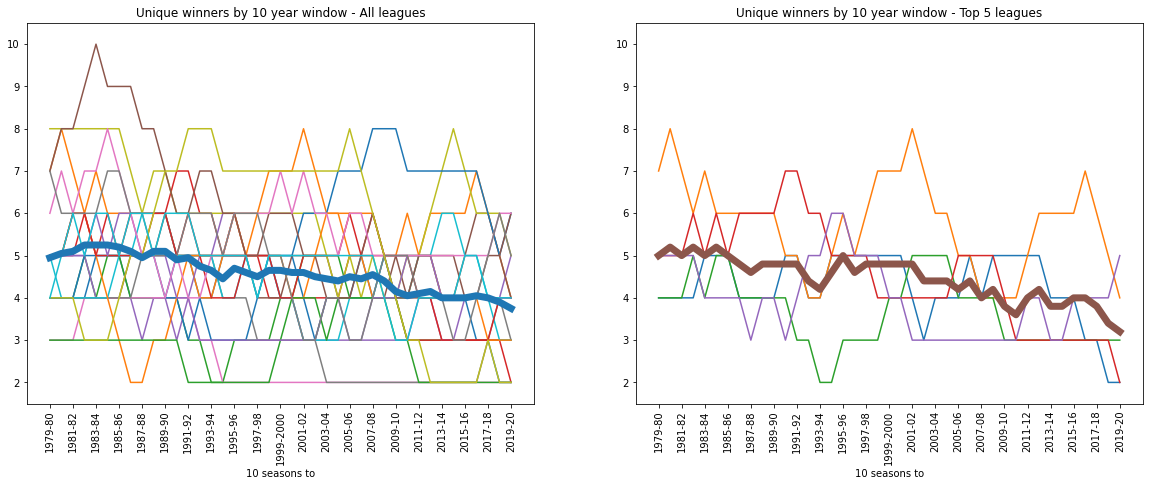

In [37]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(unique_winners_mat.transpose());
ax[0].plot(np.mean(unique_winners_mat,axis=0),linewidth=7.0)
ax[0].set_xticks(range(0,len(seasons_axis),2))
ax[0].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[0].set_ylim((1.5,10.5))
ax[0].set_xlabel('10 seasons to')
ax[0].set_title('Unique winners by 10 year window - All leagues')
ax[1].plot(unique_winners_mat[:5,:].transpose());
ax[1].plot(np.mean(unique_winners_mat[:5,:],axis=0),linewidth=7.0);
ax[1].set_xticks(range(0,len(seasons_axis),2))
ax[1].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[1].set_ylim((1.5,10.5))
ax[1].set_xlabel('10 seasons to')
ax[1].set_title('Unique winners by 10 year window - Top 5 leagues')
plt.show()

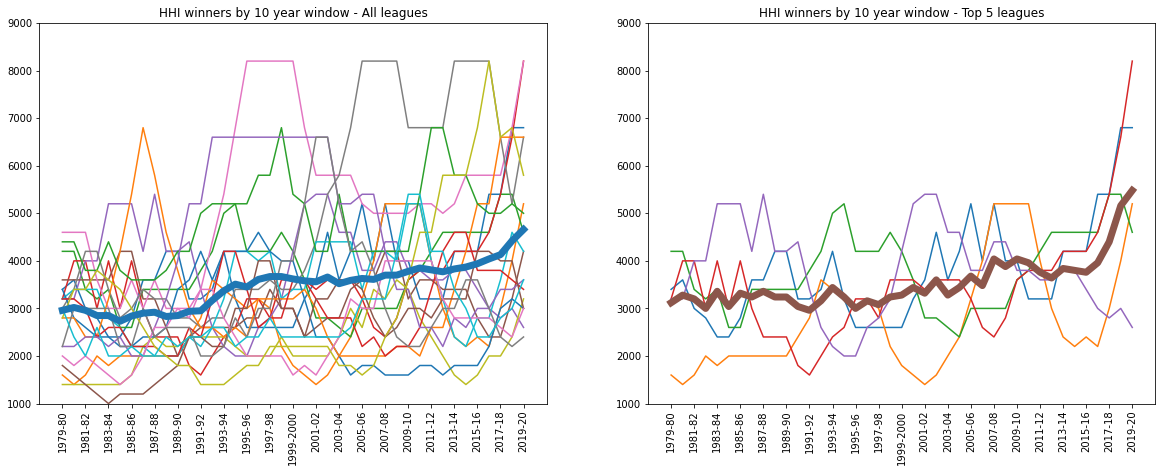

In [38]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(hhi_winners_mat.transpose());
ax[0].plot(np.mean(hhi_winners_mat,axis=0),linewidth=7.0)
ax[0].set_xticks(range(0,len(seasons_axis),2))
ax[0].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[0].set_ylim((1000,9000))
ax[0].set_title('HHI winners by 10 year window - All leagues')
ax[1].plot(hhi_winners_mat[:5,:].transpose());
ax[1].plot(np.mean(hhi_winners_mat[:5,:],axis=0),linewidth=7.0);
ax[1].set_xticks(range(0,len(seasons_axis),2))
ax[1].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[1].set_ylim((1000,9000))
ax[1].set_title('HHI winners by 10 year window - Top 5 leagues')
plt.show()

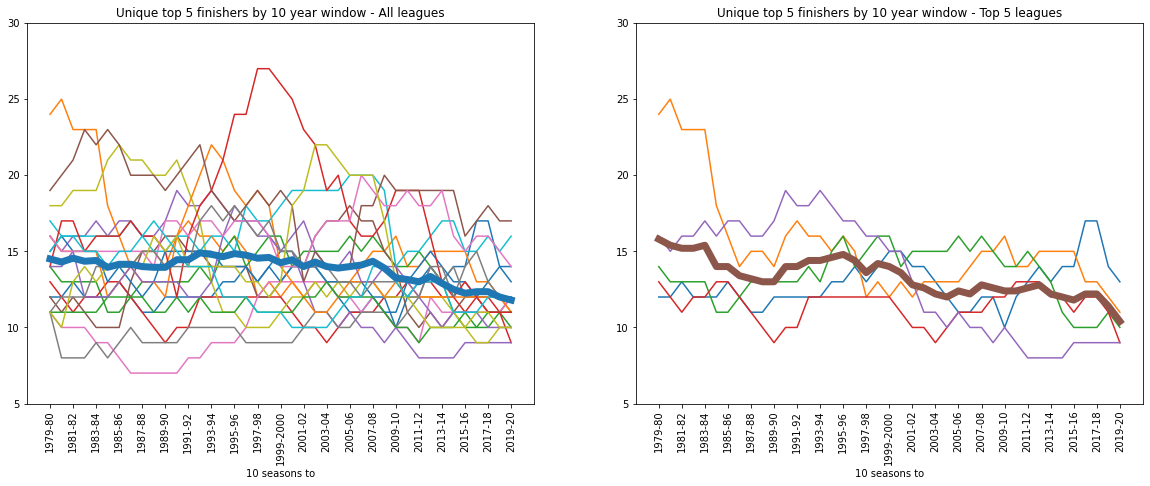

13

In [39]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(unique_top5_mat.transpose());
ax[0].plot(np.mean(unique_top5_mat,axis=0),linewidth=7.0)
ax[0].set_xticks(range(0,len(seasons_axis),2))
ax[0].set_xlabel('10 seasons to')
ax[0].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[0].set_ylim((5,30))
ax[0].set_title('Unique top 5 finishers by 10 year window - All leagues')
ax[1].plot(unique_top5_mat[:5,:].transpose());
ax[1].plot(np.mean(unique_top5_mat[:5,:],axis=0),linewidth=7.0);
ax[1].set_xticks(range(0,len(seasons_axis),2))
ax[1].set_xlabel('10 seasons to')
ax[1].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[1].set_ylim((5,30))
ax[1].set_title('Unique top 5 finishers by 10 year window - Top 5 leagues')
plt.show()
np.argmax(np.max(unique_top5_mat,axis=1))

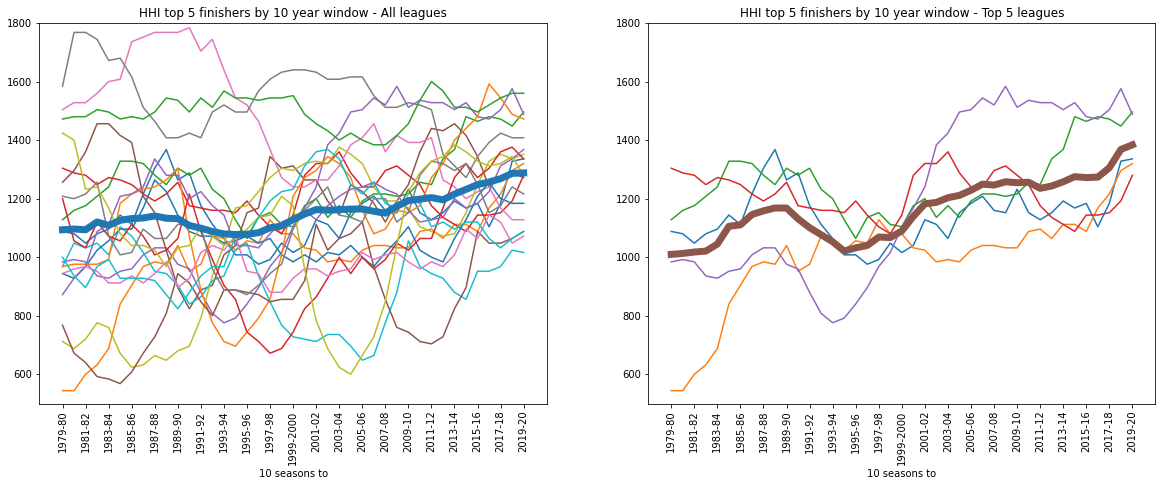

In [40]:
fig,ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(hhi_top_5_mat.transpose());
ax[0].plot(np.mean(hhi_top_5_mat,axis=0),linewidth=7.0)
ax[0].set_xlabel('10 seasons to')
ax[0].set_xticks(range(0,len(seasons_axis),2))
ax[0].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[0].set_ylim((500,1800))
ax[0].set_title('HHI top 5 finishers by 10 year window - All leagues')
ax[1].plot(hhi_top_5_mat[:5,:].transpose());
ax[1].plot(np.mean(hhi_top_5_mat[:5,:],axis=0),linewidth=7.0);
ax[1].set_xlabel('10 seasons to')
ax[1].set_xticks(range(0,len(seasons_axis),2))
ax[1].set_xticklabels(np.array(seasons_axis)[range(0,len(seasons_axis),2)],rotation=90)
ax[1].set_ylim((500,1800))
ax[1].set_title('HHI top 5 finishers by 10 year window - Top 5 leagues')
plt.show()


The above pictures speak for themselves, but just to spell it out, there is an evident trend towards more monopolistic leagues across all European top divisions, and the trend is strongest in the top five leagues.

# Scotland and Portugal

Finally I consider to Scotland and Portugal, which seem to be historically the least competitive leagues. Of the 86 seasons the Portuguese top division has been contested, the big three of Sporting, Benfica and Porto have between them won it 84 times.
In Scotland one of the so-called Old Firm of Rangers and Celtic have won the league every year since 1985 and on three seperate occasions one or other club has won nine consecutive titles. 


In [41]:
idx_sp = np.where(np.array(country_list)=='Scotland')[0][0]
sp = all_leagues[idx_sp]
idx_ppl = np.where(np.array(country_list)=='Portugal')[0][0]
ppl = all_leagues[idx_ppl]

# clean up data
for table in sp.tables:
  table.Team = [re.sub('[\(\[].*[\)\]]','',t).strip() for t in table.Team] 
  table.Pts = [re.sub('[\(\[].*[\)\]]','',p).strip() for p in table.Pts] 
for table in ppl.tables:
  table.Team = [re.sub('[\(\[].*[\)\]]','',t).strip() for t in table.Team] 
  table.Pts = [re.sub('[\(\[].*[\)\]]','',p).strip() for p in table.Pts] 


The next tables show the extent of the dominance, with the 5 clubs in question  finishing outside the top 5 on only a handful of occasions.

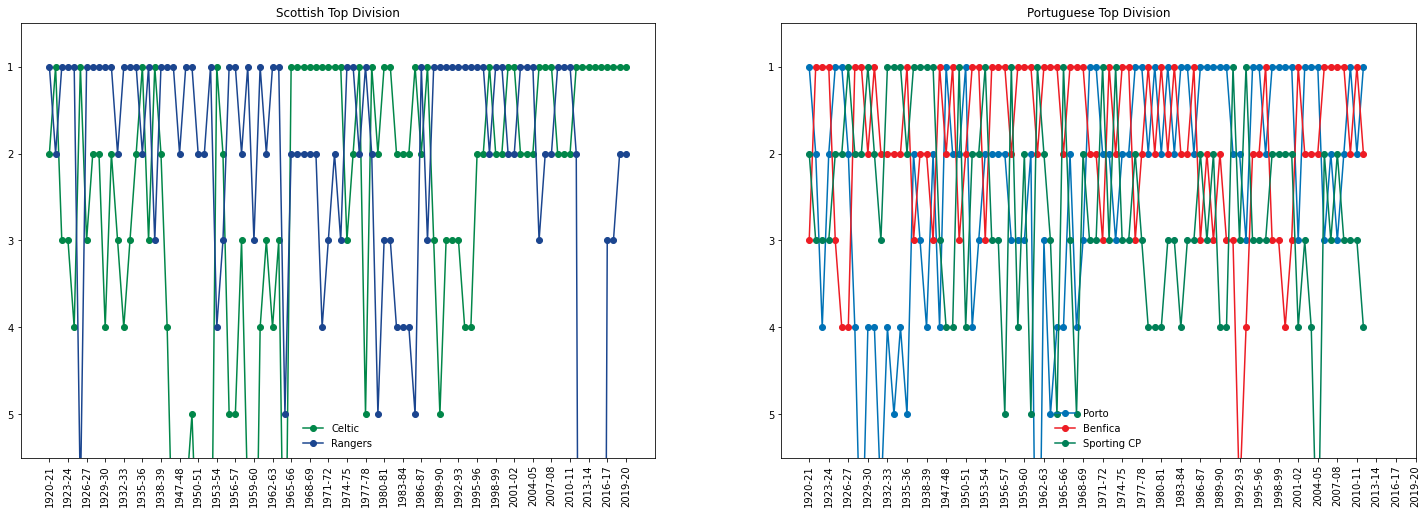

In [42]:
def position(table,team):
  pos = table.loc[table.Team==team,'Pos'].values
  if len(pos) == 0:
    return np.nan
  else:
    return pos[0]
ppl.tables[-1]
pos_sp = []
pos_ppl = []
celtic_hex = '#018749'
rangers_hex = '#1b458f'
benfica_hex = '#ed1c24'
porto_hex = '#0072B6'
sporting_hex = '#008057'

for v in['Celtic','Rangers']:
  pos_sp.append(np.array([position(table,v) for table in sp.tables]))
pos_sp = np.array(pos_sp);pos_sp[np.isnan(pos_sp)] = 20

for v in ['Porto','Benfica','Sporting CP']:
  pos_ppl.append(np.array([position(table,v) for table in ppl.tables]))
pos_ppl = np.array(pos_ppl);pos_ppl[np.isnan(pos_ppl)] = 20


fig,axes = plt.subplots(1,2,figsize=(25,8))
ax = axes[0];ax.set_title('Scottish Top Division')

ax.plot(pos_sp[0],linestyle='-',marker='o',color=celtic_hex);
ax.plot(pos_sp[1],linestyle='-',marker='o',color=rangers_hex);
ax.set_xticks(range(0,len(sp.season),3));ax.set_xticklabels(np.array(sp.season)[np.arange(0,len(sp.season),3)],rotation=90);
fig.gca().invert_yaxis()
ax.set_ylim(5.5,0.5)
ax.legend(('Celtic','Rangers'),loc = 'lower center',frameon=False);

ax = axes[1];ax.set_title('Portuguese Top Division')
ax.plot(pos_ppl[0],linestyle='-',marker='o',color=porto_hex);
ax.plot(pos_ppl[1],linestyle='-',marker='o',color=benfica_hex);
ax.plot(pos_ppl[2],linestyle='-',marker='o',color=sporting_hex);
ax.set_xticks(range(0,len(sp.season),3));ax.set_xticklabels(np.array(sp.season)[np.arange(0,len(sp.season),3)],rotation=90);
fig.gca().invert_yaxis()
ax.set_ylim(5.5,0.5)
ax.legend(('Porto','Benfica','Sporting CP'),loc = 'lower center',frameon=False);


In [43]:
#create league object for only the common seasons
import copy
common_seasons = [s for s in ppl.season if s in sp.season] 
sp_c = copy.deepcopy(sp);sp_c.season=[];sp_c.url=[];sp_c.tables=[];
ppl_c = copy.deepcopy(ppl);ppl_c.season=[];ppl_c.url=[];ppl_c.tables=[];

for i,s in enumerate(sp.season):
  if s in common_seasons:
    sp_c.season.append(s)
    sp_c.url.append(sp.url[i])
    sp_c.tables.append(sp.tables[i])
for i,s in enumerate(ppl.season):
  if s in common_seasons:
    ppl_c.season.append(s)
    ppl_c.url.append(ppl.url[i])
    ppl_c.tables.append(ppl.tables[i])

unique_winners_rolling_sp, unique_top5_rolling_sp, hhi_winners_rolling_sp, hhi_top_5_rolling_sp,seasons_axis_sp = rolling_window_stats(sp_c,window_length)
unique_winners_rolling_ppl, unique_top5_rolling_ppl, hhi_winners_rolling_ppl, hhi_top_5_rolling_ppl,seasons_axis_ppl = rolling_window_stats(ppl_c,window_length)



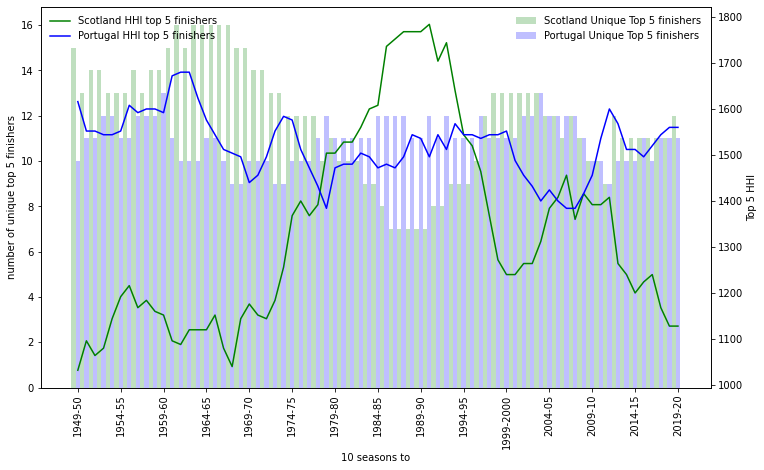

In [53]:
fig,ax1 = plt.subplots(figsize=(12,7))
x = np.arange(len(unique_top5_rolling_ppl))
#fig.suptitle(league_name+' '+ kind+' by {} season rolling window'.format(window_length))
ax1.bar(x-0.5,unique_top5_rolling_sp,color='g',width=0.5,label='Scotland Unique Top 5 finishers',alpha=0.25);
ax1.bar(x,unique_top5_rolling_ppl,color='b',width=0.5,label='Portugal Unique Top 5 finishers',alpha=0.25);
ax1.legend(loc='best',frameon=False);
ax1.set_xticks(np.arange(0,len(seasons_axis_sp),5))
ax1.set_xticklabels(np.array(seasons_axis_sp)[range(0,len(seasons_axis_sp),5)],rotation=90)
ax1.set_xlabel('10 seasons to')
ax1.set_ylabel('number of unique top 5 finishers')
ax2 = ax1.twinx()
ax2.plot(hhi_top_5_rolling_sp,label='Scotland HHI top 5 finishers',color='g');
ax2.plot(hhi_top_5_rolling_ppl,label='Portugal HHI top 5 finishers',color='b');
ax2.legend(loc='upper left',frameon=False);
ax2.set_ylabel('Top 5 HHI');
plt.show()



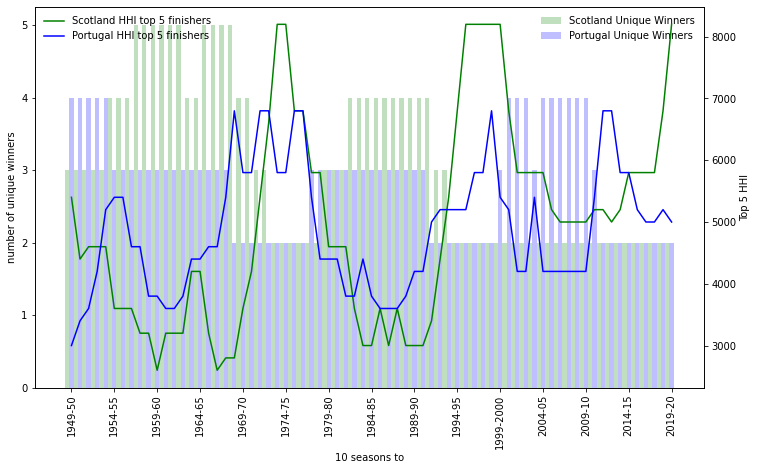

In [52]:
fig,ax1 = plt.subplots(figsize=(12,7))
x = np.arange(len(unique_winners_rolling_sp))
ax1.bar(x-0.5,unique_winners_rolling_sp,color='g',width=0.5,label='Scotland Unique Winners',alpha=0.25);
ax1.bar(x,unique_winners_rolling_ppl,color='b',width=0.5,label='Portugal Unique Winners',alpha=0.25);
ax1.legend(loc='best',frameon=False);
ax1.set_xticks(np.arange(0,len(seasons_axis_sp),5))
ax1.set_xticklabels(np.array(seasons_axis_sp)[range(0,len(seasons_axis_sp),5)],rotation=90)
ax1.set_xlabel('10 seasons to')
ax1.set_ylabel('number of unique winners')
ax2 = ax1.twinx()
ax2.plot(hhi_winners_rolling_sp,label='Scotland HHI top 5 finishers',color='g');
ax2.plot(hhi_winners_rolling_ppl,label='Portugal HHI top 5 finishers',color='b');
ax2.legend(loc='upper left',frameon=False);
ax2.set_ylabel('Top 5 HHI');
plt.show()

Portugal as a triopoly doesn't spike as highly on the winners HHI score as duopolistic Scotland, however further down the pecking order, Scotland +generally has more competition for the top 5 places. 

The maximum winners HHI score of 8,100 corresponds to those periods when a team won 9 consecutive championships. In the 2020-21 season Celtic have the chance for a 10th as do Juventus in Serie A. We could see the first "perfect" score of 10,000 on winners HHI by the end of the seaso

#Conclusion
Some leagues have always been uncompetitive and dominated by a few very large clubs. However the previous sections show that this phenomenon is becoming more and more commonplace.